# English masked language models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import lru_cache
from itertools import combinations, product
import os

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

import numpy as np
from scipy.stats import pearsonr
from tqdm import tqdm

from gest import gest, stereotype_names
from utils import bootstrap_ci, set_size, visualize_corr

In [3]:
models = [
    'bert-base-uncased',
    'roberta-base',    
    'albert-base-v2',
    'bert-base-multilingual-cased',
    'xlm-roberta-base',
    'xlm-roberta-large',
    'facebook/xlm-v-base',
    'facebook/xlm-roberta-xl',
    'distilbert-base-uncased',
    'google/electra-large-generator',
    'google/electra-base-generator',
]

def short_model_name(model):
    for s in ('uncased', 'v2', 'cased', 'generator'):
        if model.endswith('-' + s):
            model = model[:-len(s)-1]
    model = model.split('/')[-1]
    if model.endswith('lingual'):
        model = model[:-7]
    return model

In [4]:
def file_results(filename):
    return list(map(float, open(filename, 'r').readlines()))

def model_template_file(model_handle, template_id):
    model_handle = model_handle.split('/')[-1]
    return f'./data/predictions/english_mlm/{model_handle}_template-{template_id}.txt'


@lru_cache
def r_i(filename, stereotype_id, bootstrap=True):
    """
    Average score for stereotype _i_
    """
    vals = [
        val
        for val, gest_stereotype_id in zip(file_results(filename), gest.stereotype)
        if gest_stereotype_id == stereotype_id
    ]

    if bootstrap:
        return bootstrap_ci(vals)
    else:
        return np.mean(vals)

def r_is(filename, bootstrap=True):
    """
    Averages for all 16 stereotypes
    """
    return [r_i(filename, stereotype_id, bootstrap) for stereotype_id in range(1, 17)]

def r_f(filename):
    """
    Average score $r_i$ for female stereotypes
    """
    return np.mean([
        r_i(filename, stereotype_id, bootstrap=False)
        for stereotype_id in range(1, 8)
    ]) 

def r_m(filename):
    """
    Average score $r_i$ for male stereotypes
    """
    return np.mean([
        r_i(filename, stereotype_id, bootstrap=False)
        for stereotype_id in range(8, 17)
    ]) 

def g_s(filename):
    """
    Overall stereotype rate
    """
    return r_m(filename) - r_f(filename)

def r_i_ranks(filename):
    return np.argsort(np.argsort(r_is(filename, bootstrap=False))) + 1

## Basic visualizations

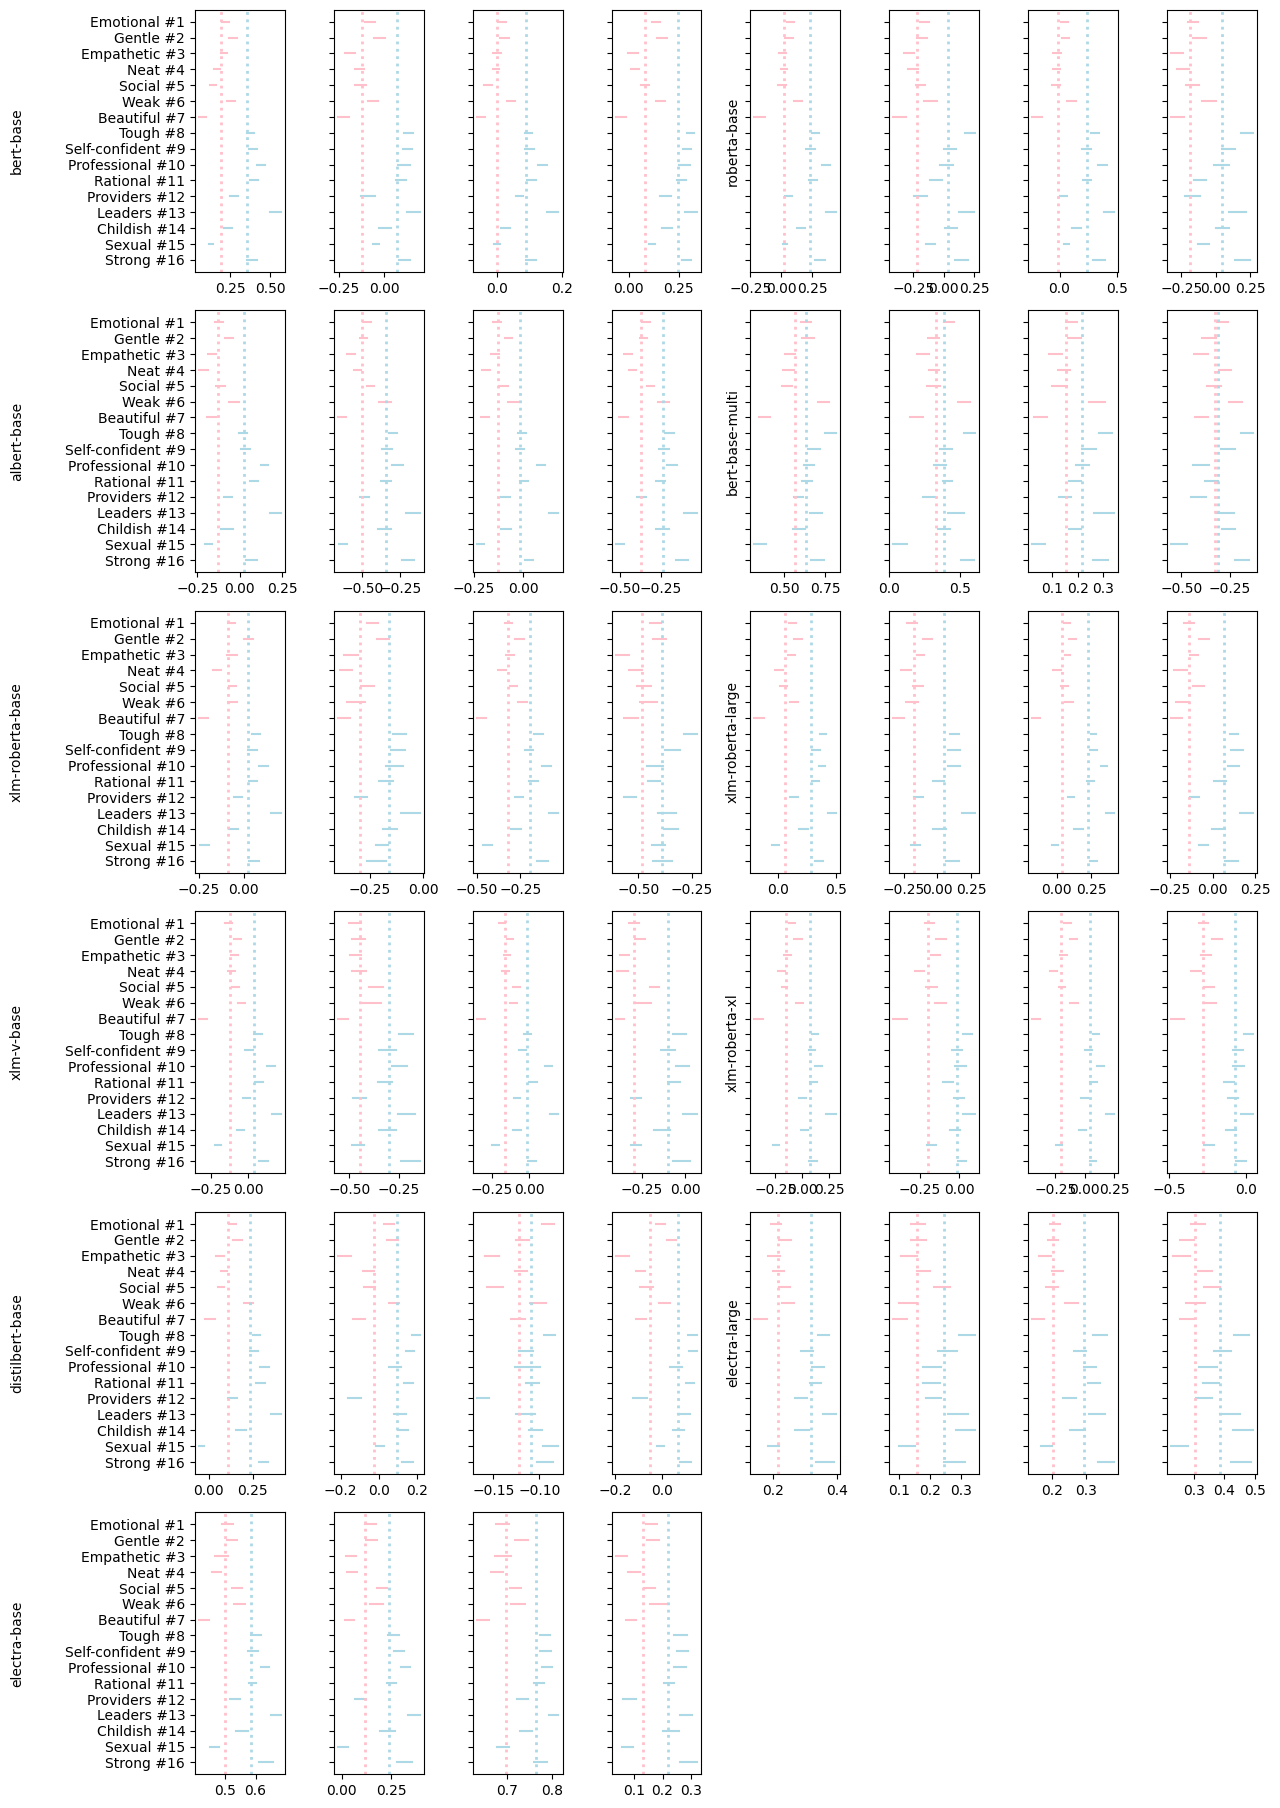

In [5]:
fig, axes = plt.subplots(6, 8, sharey=True)
axes = axes.reshape(-1)
axes[0].invert_yaxis()

for ax in axes[-4:]:
    ax.remove()

for ax, (model_handle, template_id) in zip(axes, product(models, range(4))):
    filename = model_template_file(model_handle, template_id)
    for stereotype_id in range(1, 17):
        _, lower, upper = r_i(filename, stereotype_id)
        ax.plot([lower, upper], [stereotype_id, stereotype_id], c=('pink' if stereotype_id < 8 else 'lightblue'))
    ax.set_yticks(range(1, 17), stereotype_names)
    ax.axvline(r_m(filename), linestyle=':', linewidth=2, color='lightblue')
    ax.axvline(r_f(filename), linestyle=':', linewidth=2, color='pink')
        
    if template_id == 0:
        ax.set_ylabel(short_model_name(model_handle))

set_size(10, 14)
plt.tight_layout()
plt.savefig('./figures/en_all.pdf')

In [8]:
def format_ci(mean, lower, upper):
    return f'{lower:.2f} {mean:.2f} {upper:.2f}'

for model_handle in models:
    print('\\midrule')
    print("& \multicolumn{16}{l}{\\texttt{", end='')
    print(short_model_name(model_handle), end='')
    print("}} \\\\")
    for template_id in range(4):
        print(template_id+1, *[
            format_ci(*r_i(model_template_file(model_handle, template_id), stereotype_id))
            for stereotype_id in range(1, 17)
        ], sep=' & ', end=' \\\\\n')

\midrule
& \multicolumn{16}{l}{\texttt{bert-base}} \\
1 & 0.20 0.22 0.24 & 0.24 0.27 0.29 & 0.19 0.21 0.23 & 0.15 0.17 0.18 & 0.12 0.14 0.16 & 0.23 0.26 0.28 & 0.05 0.07 0.09 & 0.35 0.38 0.40 & 0.36 0.39 0.42 & 0.42 0.44 0.47 & 0.37 0.40 0.43 & 0.25 0.27 0.30 & 0.50 0.53 0.57 & 0.21 0.23 0.26 & 0.11 0.13 0.14 & 0.36 0.39 0.42 \\
2 & -0.11 -0.08 -0.05 & -0.06 -0.03 0.00 & -0.22 -0.19 -0.16 & -0.16 -0.14 -0.11 & -0.16 -0.13 -0.10 & -0.09 -0.06 -0.03 & -0.26 -0.23 -0.20 & 0.11 0.14 0.16 & 0.10 0.13 0.16 & 0.08 0.11 0.14 & 0.07 0.09 0.12 & -0.12 -0.09 -0.05 & 0.13 0.16 0.19 & -0.02 0.01 0.04 & -0.06 -0.05 -0.03 & 0.08 0.11 0.14 \\
3 & 0.00 0.01 0.03 & 0.01 0.02 0.04 & -0.01 0.00 0.01 & -0.01 -0.00 0.01 & -0.04 -0.03 -0.02 & 0.03 0.04 0.05 & -0.06 -0.05 -0.04 & 0.09 0.10 0.11 & 0.09 0.10 0.11 & 0.13 0.14 0.15 & 0.09 0.11 0.12 & 0.06 0.07 0.08 & 0.15 0.17 0.19 & 0.01 0.02 0.04 & -0.01 -0.00 0.01 & 0.09 0.10 0.12 \\
4 & 0.12 0.14 0.16 & 0.14 0.17 0.19 & 0.00 0.02 0.05 & 0.01 0.03 0.05 & 0.06 

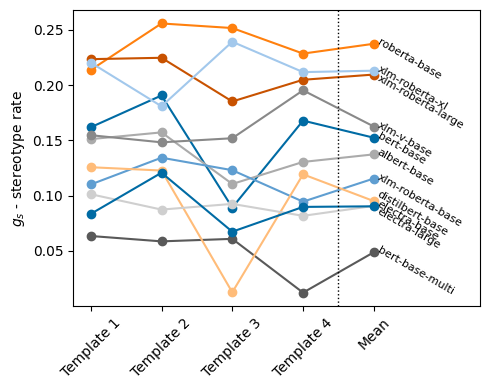

In [9]:
"""
The results are pretty consistent across different templates - This is often not the case with other measures.

The only exception is template #3 with BERT and DistilBERT (note that DistilBERT is directly distilled from the original BERT).
Not sure why that is the case, but it might simply expect different pronouns there.
"""

plt.rcParams["figure.figsize"] = (5,4)

for model_handle in models:
    rates = [
        g_s(model_template_file(model_handle, template_id))
        for template_id in range(4)
    ]
    plt.plot(range(1,6), rates + [np.mean(rates)], marker='o')
    model_handle = short_model_name(model_handle)
    ver_offset = {'distilbert-base': 0.005, 'xlm-roberta-large': -0.005, 'electra-large': -0.007}.get(model_handle, 0)
    plt.text(5 + 0.04, np.mean(rates) + ver_offset, model_handle, fontsize=8, rotation=-30, rotation_mode='anchor')
plt.axvline(4.5, linestyle=':', linewidth=1, color='black')
plt.xticks(range(1, 6), [f'Template {i}' for i in range(1, 5)] + ['Mean'], rotation=45)
plt.xlim(0.75, 6.5)
plt.ylabel('$g_s$ - stereotype rate')
plt.tight_layout()
plt.savefig('./figures/en_templates.pdf')

/tmp/ipykernel_1142/77845829.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  results = np.vstack(


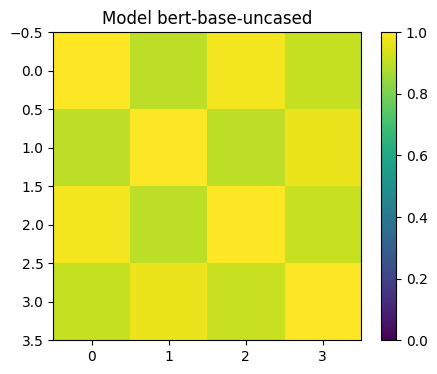

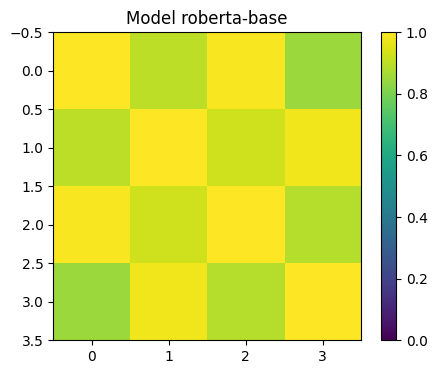

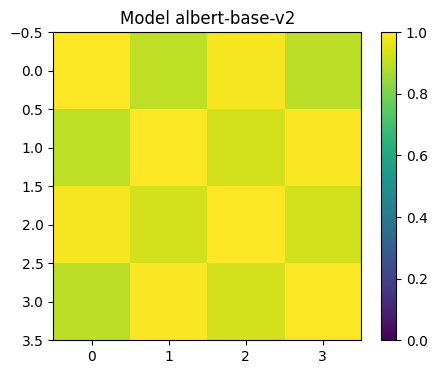

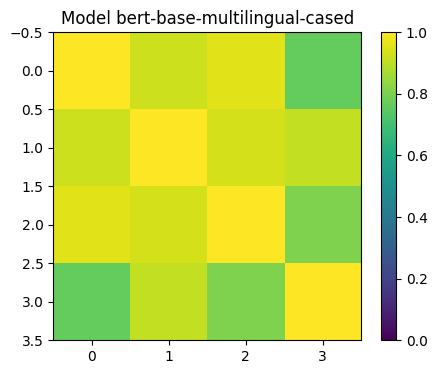

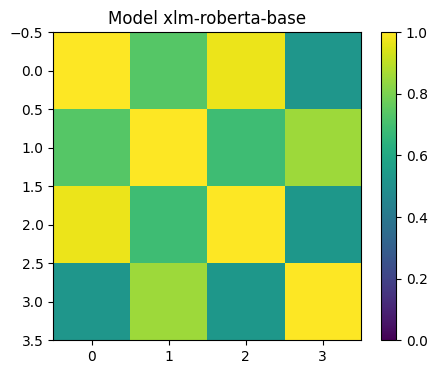

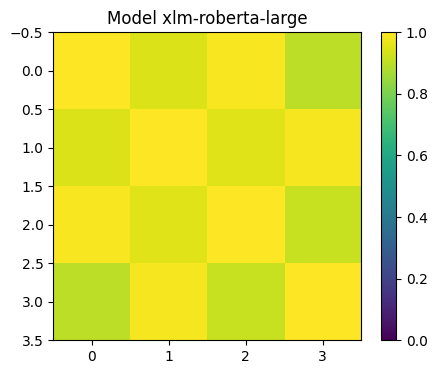

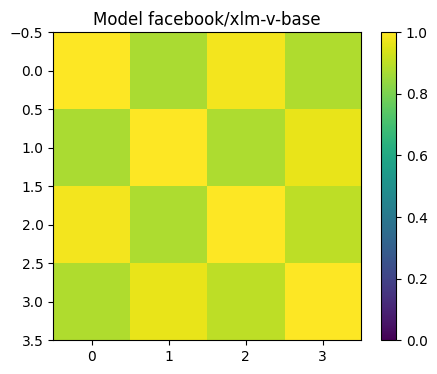

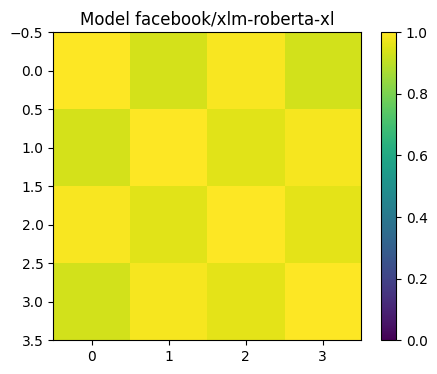

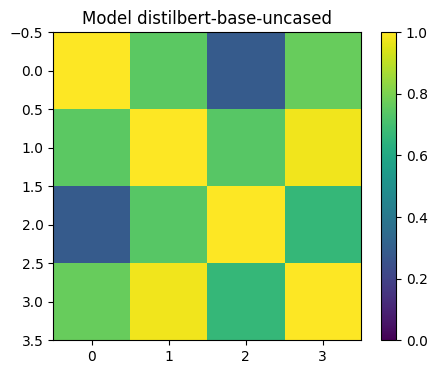

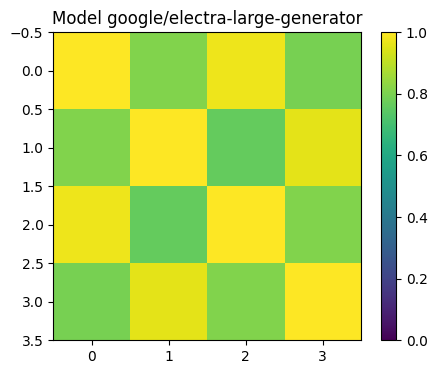

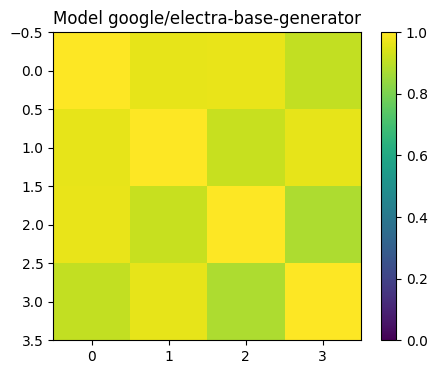

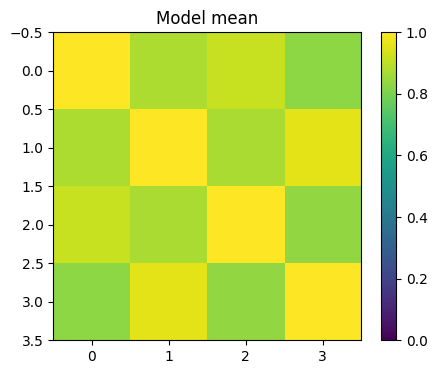

In [11]:
"""
Template correlations.

The correlations are quite strong (0.6+). Correlations between templates that use the same words (X he said, He said X) are much stronger.
This shows certain lexical consistency, that is not the same when we change the gender identifier (he > the man).
"""
corrs = []
for model_handle in models:
    results = np.vstack(
        r_is(model_template_file(model_handle, template_id), bootstrap=False)
        for template_id in range(4)
    )
    corr = np.corrcoef(results)
    corrs.append(corr)
    plt.title(f'Model {model_handle}')
    visualize_corr(corr)

mean_corrs = np.mean(np.array(corrs), axis=0)
plt.title(f'Model mean')
visualize_corr(mean_corrs)

/tmp/ipykernel_1142/3613757555.py:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  results = np.vstack(


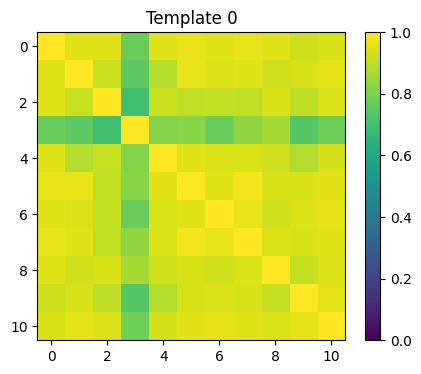

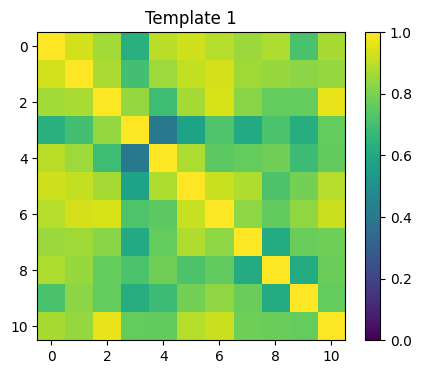

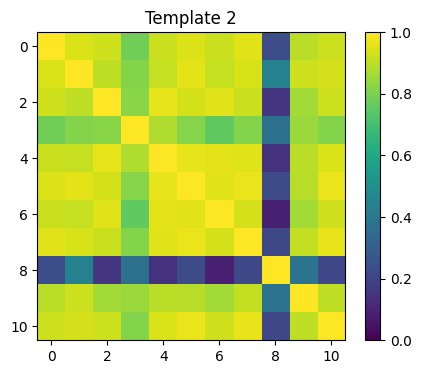

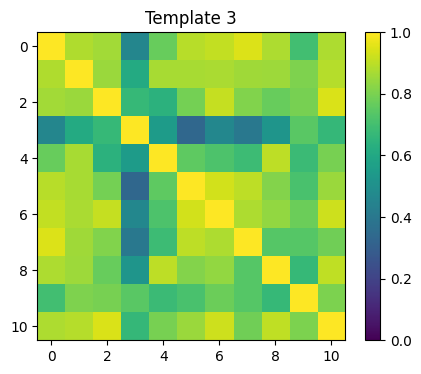

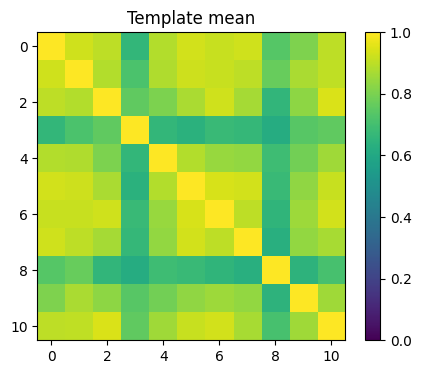

In [12]:
"""
Model correlations.

How the results correlate between models. The correlations are weaker overall (0.5), and they do not say that much.
Only visible pattern is that MBERT is less correlated to the other models.
"""

corrs = []
for template_id in range(4):
    results = np.vstack(
        r_is(model_template_file(model_handle, template_id), bootstrap=False)
        for model_handle in models
    )
    corr = np.corrcoef(results)
    plt.title(f'Template {template_id}')
    visualize_corr(corr)
    corrs.append(corr)

mean_corr = np.mean(np.array(corrs), axis=0)
plt.title(f'Template mean')
visualize_corr(mean_corr)

Text(0.5, 1.0, 'Normalized')

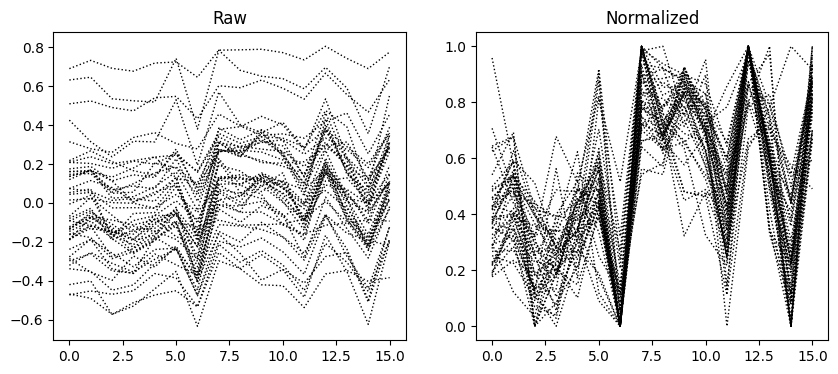

In [13]:
"""
Some (model, template) combinations show either masculine or feminine preference. The stereotypical reasoning is similar in
all of them (the lines are similar), but the base rate (masculine/feminine preference) is different.
"""
plt.rcParams["figure.figsize"] = (10,4)

_, axes = plt.subplots(1, 2)

for model_handle, template_id in product(models, range(4)):
    arr = r_is(model_template_file(model_handle, template_id), bootstrap=False)
    arr = np.array(arr)
    axes[0].plot(arr, c='black', linestyle=':', linewidth=1)
    arr -= min(arr)
    arr /= max(arr)
    axes[1].plot(arr, c='black', linestyle=':', linewidth=1)
axes[0].set_title('Raw')
axes[1].set_title('Normalized')



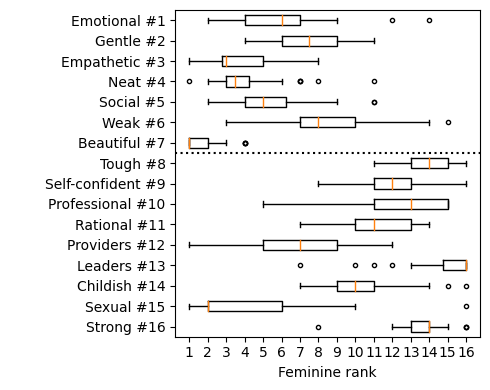

In [14]:
"""
Boxplot of positions (the rank in the list of 16 stereotypes) for all stereotypes.
"""
plt.rcParams["figure.figsize"] = (5,4)

ranks = np.vstack([
    r_i_ranks(model_template_file(model_handle, template_id))
    for model_handle in models
    for template_id in range(4)
])
plt.boxplot([ranks[:,i] for i in range(16)], vert=False, sym='.')
plt.axhline(7.5, c='black', linestyle=':')
plt.gca().invert_yaxis()
plt.xticks(range(1,17))
plt.yticks(range(1,17), stereotype_names)
plt.xlabel('Feminine rank')
plt.tight_layout()
plt.savefig('./figures/en_ranks.pdf')

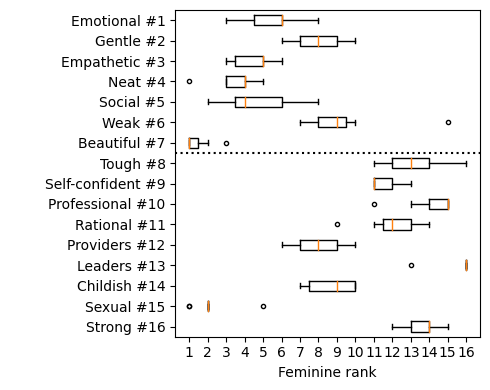

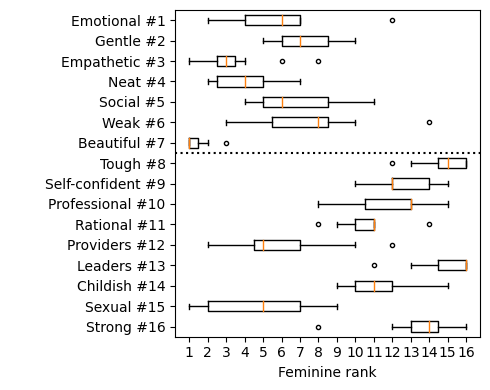

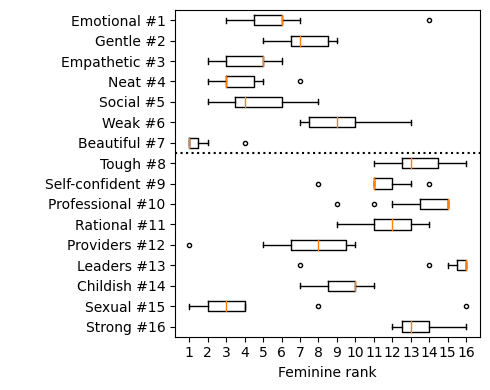

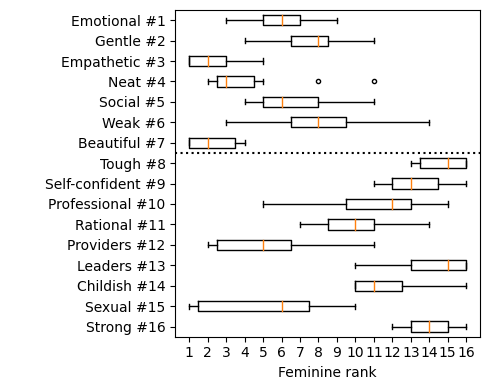

In [15]:
"""
Boxplots for templates. They look pretty similar to each other. "he/she" templates are more consistent than "man/woman".
"""
plt.rcParams["figure.figsize"] = (5,4)

for template_id in range(4):
    ranks = np.vstack([
        r_i_ranks(model_template_file(model_handle, template_id))
        for model_handle in models
    ])
    plt.boxplot([ranks[:,i] for i in range(16)], vert=False, sym='.')
    plt.axhline(7.5, c='black', linestyle=':')
    plt.gca().invert_yaxis()
    plt.xticks(range(1,17))
    plt.yticks(range(1,17), stereotype_names)
    plt.xlabel('Feminine rank')
    plt.tight_layout()
    plt.show()


## Correlation

Correlations calculated across scores for individual instances `instance_results` and score for stereotypes `r_i_results`.

In [16]:
instance_results = {
    (model_handle, template_id): file_results(model_template_file(model_handle, template_id))
    for model_handle, template_id in product(models, range(4))
}
r_i_results = {
    (model_handle, template_id): r_is(model_template_file(model_handle, template_id), bootstrap=False)
    for model_handle, template_id in product(models, range(4))
}

In [17]:
"""
Mean correlation between models
"""
(
    np.mean([
        np.mean([
            pearsonr(instance_results[model1, template], instance_results[model2, template])[0]
            for model1, model2 in combinations(models, 2)
        ])
        for template in range(4)
    ]),
    
    np.mean([
        np.mean([
            pearsonr(r_i_results[model1, template], r_i_results[model2, template])[0]
            for model1, model2 in combinations(models, 2)
        ])
        for template in range(4)
    ])
)

(0.48817286899183115, 0.8159441248630586)

In [18]:
"""
Mean correlation between templates
"""
(
    np.mean([
        np.mean([
            pearsonr(instance_results[model, template1], instance_results[model, template2])[0]
            for template1, template2 in combinations(range(4), 2)
        ])
        for model in models
    ]),
    
    np.mean([
        np.mean([
            pearsonr(r_i_results[model, template1], r_i_results[model, template2])[0]
            for template1, template2 in combinations(range(4), 2)
        ])
        for model in models
    ])
)

(0.7191824940655134, 0.8817579292755547)

## MultiBERT

We do not include the predictions calculated for MultiBERT within the repository due to its size (50MB), but the inference code is available.

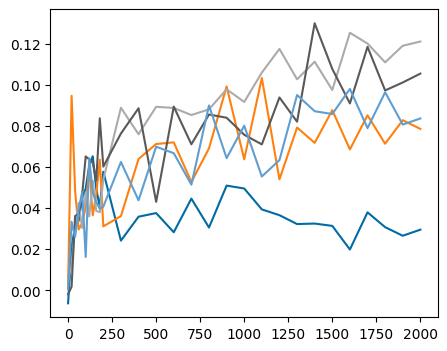

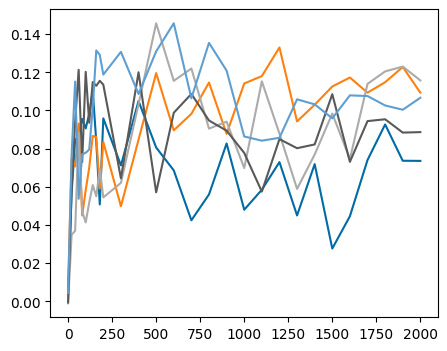

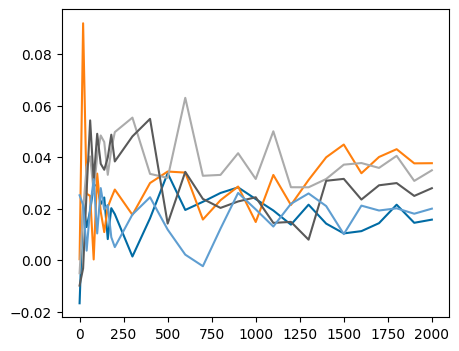

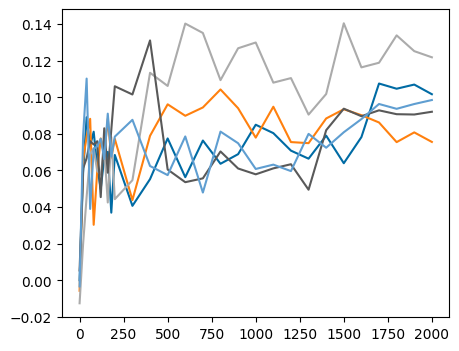

In [19]:
"""
Evolution during a BERT training run. Seems pretty consistent after the initial spike.

Template #3 is a bit lower, similar to how it behaves for regular BERT in Figure 4. This suggest that the drop there
is somehow connected to the data.
"""

import glob
import re

pred_files = glob.glob('./cache/predictions/multibert/*seed_0*')
steps = sorted(set(
    int(re.findall(r'([0-9]+)k', filename)[0])
    for filename in pred_files
    if 'k' in filename
))

def multibert_filename(seed_id, step_count, template_id):
    return f'./cache/predictions/multibert/multiberts-seed_{seed_id}-step_{step_count}k_template-{template_id}.txt'


for template_id in range(4):
    for seed_id in range(5):
        plt.plot(
            steps,
            [
                g_s(multibert_filename(seed_id, step, template_id))
                for step in steps
            ]
        )
    plt.show()

/tmp/ipykernel_1142/2943152320.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  results = np.vstack(


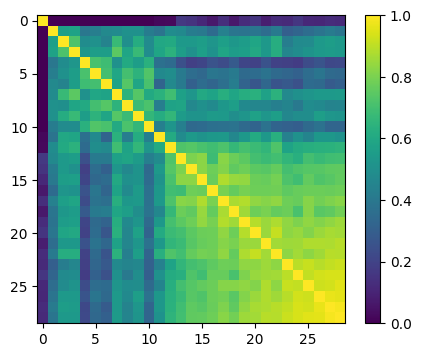

In [20]:
"""
Correlation of the scores for individual checkpoints.
"""
results = np.vstack(
    file_results(multibert_filename(0, step, 0))
    for step in steps
)
corr = np.corrcoef(results)
visualize_corr(corr)

## Family-related terms

0.10356665294061326 -0.03769059379283133 -0.06458755152408129


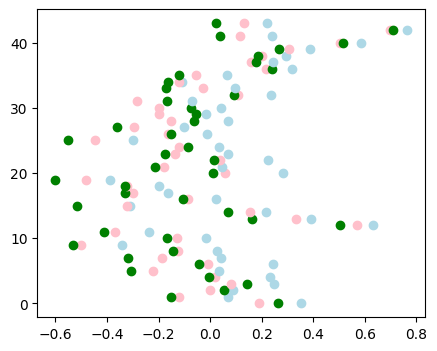

In [21]:
family_words = 'family child children partner kids kid family\'s'.split()

def family_rate(filename):
    return np.mean([
        val
        for val, sentence, stereotype_id in zip(file_results(filename), gest.sentence, gest.stereotype)
        if any(word in sentence for word in family_words) and stereotype_id > 7
    ])

al, bl, cl = [], [], []
for i, (model_handle, template_id) in enumerate(product(models, range(4))):
    filename = model_template_file(model_handle, template_id)
    a, b, c = r_m(filename), r_f(filename), family_rate(filename)
    plt.scatter([a], [i], c='lightblue')
    plt.scatter([b], [i], c='pink')
    plt.scatter([c], [i], c='green')
    al.append(a); bl.append(b); cl.append(c)
print(np.mean(al), np.mean(bl), np.mean(cl))
